In [13]:
from meta_transformer import transformer
import jax
from jax import random, vmap, grad, jit, value_and_grad
import jax.numpy as jnp
import haiku as hk
from jax import nn
from meta_transformer import utils
import optax
import numpy as np
import matplotlib.pyplot as plt
import time
import functools
import datasets
import dataclasses
from typing import Mapping, Any, Tuple, List
import chex


rng = random.PRNGKey(42)


# Model
def forward(input_chunks, is_training=True):
    t = transformer.Classifier(
        transformer=transformer.Transformer(
            num_heads=2, #4,
            num_layers=6,
            key_size=32,
            dropout_rate=0.1,
        ),
        model_size=64,
        num_classes=10,
    )
    return t(input_chunks, is_training=is_training)


model = hk.transform(forward)


@functools.partial(jit, static_argnums=3)
def loss(params, rng, data, is_training=True):
    """data is a dict with keys 'img' and 'label'."""
    input_chunks, targets = data["img"], data["label"]
    targets = nn.one_hot(targets, 10)
    logits = model.apply(params, rng, input_chunks, is_training)[:, 0, :]  # [B, C]
    chex.assert_equal_shape(logits, targets)
    return -jnp.sum(targets * nn.log_softmax(logits, axis=-1), axis=-1).mean()


# Data and metrics
train_data, test_data = utils.load_data("cifar10")


@functools.partial(jit, static_argnums=3)
def accuracy(rng, params, data, is_training=True):
    """data is a dict with keys 'img' and 'label'. labels are NOT one-hot."""
    targets, inputs = data["label"], data["img"]
    logits = model.apply(params, rng, inputs, is_training)[:, 0, :]
    predictions = jnp.argmax(logits, axis=-1)
    return jnp.mean(predictions == targets)


@jit
def val_metrics(rng, params):
    """Compute acc and loss on test set."""
    rngs = random.split(rng, 3)
    tdata = test_data[:]
    tdata["img"] = utils.process_batch(rngs[0], tdata["img"], augment=False)
    acc = accuracy(rngs[1], params, tdata, is_training=False)
    l = loss(params, rngs[2], tdata, is_training=False)
    return {"val/acc": acc, "val/loss": l}

Found cached dataset cifar10 (/home/lauro/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4)
100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 419.64it/s]


In [42]:
# Optimizer and update function
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-3
BATCH_SIZE = 512
opt = optax.adamw(LEARNING_RATE, weight_decay=WEIGHT_DECAY)


@chex.dataclass
class TrainState:
    step: int
    rng: random.PRNGKey
    opt_state: optax.OptState
    params: dict


class Updater: # Could also make this a function of opt.update, loss_fn, model.apply, etc if we want to be flexible
    """Holds training methods. All methods are jittable."""
    @functools.partial(jit, static_argnums=0)
    def init_params(self, rng: jnp.ndarray, data: dict) -> dict:
        """Initializes state of the updater."""
        out_rng, k0, k1 = jax.random.split(rng, 3)
        params = model.init(k1, utils.process_batch(k0, data["img"]))
        opt_state = opt.init(params)
        return TrainState(
            step=0,
            rng=out_rng,
            opt_state=opt_state,
            params=params,
        )
    
    @functools.partial(jit, static_argnums=0)
    def update(self, state: TrainState, data: dict) -> TrainState:
        state.rng, *subkeys = jax.random.split(state.rng, 3)
        data["img"] = utils.process_batch(subkeys[0], data["img"])
        grads = grad(loss)(state.params, subkeys[1], data)       
        updates, state.opt_state = opt.update(grads, state.opt_state, state.params)
        state.params = optax.apply_updates(state.params, updates)
        state.step += 1
        return state

    @functools.partial(jit, static_argnums=0)
    def compute_validation_metrics(self, state: TrainState) -> Tuple[TrainState, dict]:
        state.rng, subkey = random.split(state.rng)
        return state, val_metrics(subkey, state.params)
    
    @functools.partial(jit, static_argnums=0)
    def compute_metrics(self, state: TrainState, data: dict) -> Tuple[TrainState, dict]:
        state.rng, *subkeys = random.split(state.rng, 4)
        data["img"] = utils.process_batch(subkeys[0], data["img"])
        train_acc = accuracy(subkeys[1], state.params, data)
        train_loss = loss(state.params, subkeys[2], data)
        state, val_metrics = self.compute_validation_metrics(state)
        return state, {"train/acc": train_acc, **val_metrics}

In [44]:
updater = Updater()
state = updater.init_params(rng, train_data[:2])
print("Number of parameters:", sum([x.size for x in jax.tree_util.tree_leaves(state.params)]) / 1e6, "Million")

Number of parameters: 0.320586 Million


In [41]:
metrics_list = []
for batch in train_data.iter(batch_size=BATCH_SIZE):
    if state.step % 100 == 0:
        state, metrics = updater.compute_metrics(state, batch)
        metrics_list.append(metrics)
    state = updater.update(state, batch)

In [21]:
metrics = utils.dict_concatenate(metrics_list)

print("Final training accuracy:", metrics["train/acc"][-1])
print("Final test accuracy:", metrics["val/acc"][-1])

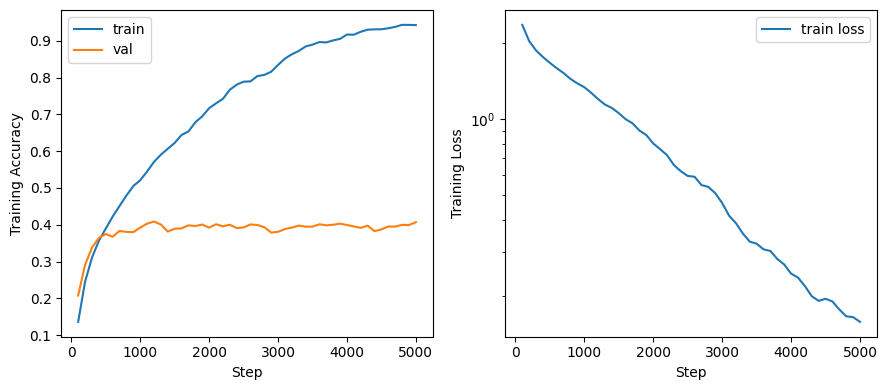

In [ ]:
# Plot
fig, axs = plt.subplots(1, 2, figsize=(9, 4))

# acc
ax = axs[0]
ax.plot(metrics["step"], metrics["train_acc"], label="train acc")
ax.plot(metrics["step"], metrics["val_acc"], label="val acc")
ax.set_ylabel("Training Accuracy")
ax.set_xlabel("Step")
ax.legend()

# loss
ax = axs[1]
ax.plot(metrics["step"], metrics["train/loss"], label="train loss")
ax.plot(metrics["step"], metrics["val/loss"], label="val loss")
ax.set_ylabel("Training Loss")
ax.set_xlabel("Step")
ax.set_yscale("log")
ax.legend()

fig.tight_layout()
plt.show()